  Activating project at `~/LCP/fish-track/HMC`


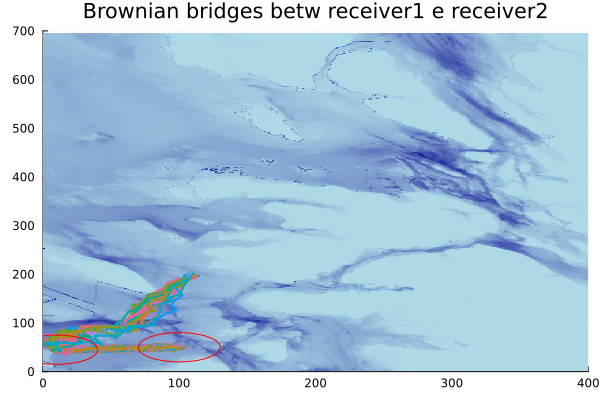

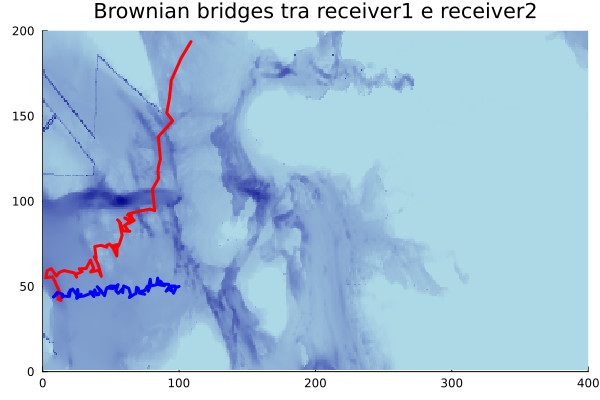

[ Info: Optimizing posterior for a MAP starting point…


Running with n_chains=12, n_rounds=8, repetition=1
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
  scans     restarts      Λ        time(s)    allc(B)  log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          0       1.33      0.871   4.02e+08       -341   1.64e-14      0.879          1          1 
        4          0      0.787      0.806   7.59e+08       -337      0.708      0.928          1          1 
        8          0       1.87       1.46   1.51e+09       -310      0.471       0.83          1          1 
       16          1       1.87       2.81   3.02e+09       -310      0.627       0.83          1          1 
       32          1       1.85       5.61   6.08e+09       -310      0.696      0.832          1          1 
       64          7       2.11       11.6   1.21e+10       -310     

In [1]:
## Find a fish with HMC
##
## February 15, 2024 -- Andreas Scheidegger
## andreas.scheidegger@eawag.ch
## -------------------------------------------------------

import Pkg

# prior for sigma  -> reference
# explorers
# way to parallelize

Pkg.activate(".")
Pkg.instantiate()

using Images: load, Gray, channelview
using Plots

include("find_grid.jl")
gr()

# -----------
# Notes
#
# - N.B., this is prototype and is not working properly!!!
# - Meaning, even with simple simulated data it does not converge.
#
# Potential issues / todos:
#
# - land/no land results currently in a discontinuity in `log_prob_signal`, something HMC
#   does not like at all. We should smooth this somehow.
#   A simple unbounded likelihood (e.g. normal), however results in trajectories that are
#   often on land, or are even leaving the bounding box. Hence, we need a smarter formulation for that.
#
# - Use better initial values, i.e. optimize the posterior first. This alone may already
#   be a challenging.
#
# - Try Enzyme.jl or Mooncake.jl for faster Automatic differentiation
#
# - Test HMC with tempering:
#   - Pigeons.jl
#   - MCMCTempering.jl ?
#
# - Test Repelling-Attracting HMC?  https://github.com/sidv23/ra-hmc


#--------- basics
# Load bathymetry, negative values are treated as land:
#bathymetry_map = channelview(Gray.(load("C:\\Users\\teresa i robert\\Desktop\\Physics of Data\\PoD Fish tracking\\Code\\fish_tracking_HMC\\HMC\\bathymetry_maps\\map_channel_mazemod2.jpg"))) * 100 .- 1;
bathymetry_map = channelview(Gray.(load("bathymetry_maps/map_Firth_of_Lorn_200m.tif"))) * 100 .- 1;
bathymetry_int = extrapolate(interpolate(bathymetry_map, BSpline(Linear())),-1.0);

receiver1 = Receiver((x=10, y=45), k=30.0, dist=30.0)
receiver2 = Receiver((x=100, y=50), k=30, dist=30.0)
receiver3 = Receiver((x=110, y=200), k=30.0, dist=30.0)
#receiver3 = Receiver((x=300, y=100), k=30.0, dist=30.0)
#--------- bridges
#Building bridges from receiver1 to receiver 2, which is a way to get all (if n_bridges, tmax and sigma are big enough to explore all the channels) the plausible 
#paths that the fish may have followed:
tmax = 80       




n_bridges = 500
bridges = []
for _ in 1:n_bridges
    bridge = simulate_bridge_2(tmax; A=receiver1, B=receiver2, σ=3, α=0.7, bathymetry_int=bathymetry_int)
    if bridge !== nothing
        push!(bridges, bridge)
    end
end

for _ in 1:100
    bridge = simulate_bridge(tmax; A=receiver1, B=receiver3, σ=3, α=0.7, bathymetry_int=bathymetry_int)
    if bridge !== nothing
        push!(bridges, bridge)
    end
end

#bridge = simulate_bridge(tmax; A=receiver1, B=receiver3, σ=3.0, α=0.7, bathymetry_int=bathymetry_int)
#push!(bridges, bridge)  

bridges = filter(!isnothing, bridges)  # keep just the valid trajectories
bridges_x = [[p.x for p in bridge] for bridge in bridges]
bridges_y = [[p.y for p in bridge] for bridge in bridges]


plt = heatmap(bathymetry_map[end:-1:1,:],
              xlim=(0, 400), ylim=(0, 700),
              color=:blues,
              legend=false,
              title="Brownian bridges betw receiver1 e receiver2")
for i in 1:length(bridges)
    plot!(plt, bridges_x[i], bridges_y[i], lw=2)
end
plot!(plt, make_circle(receiver1.x, receiver1.y, receiver1.dist), color=:red, label="Receiver 1")
plot!(plt, make_circle(receiver2.x, receiver2.y, receiver2.dist), color=:red, label="Receiver 1")
display(plt)

s_depth = bridges[1] #The trajectory from which we extract the depth data
s_init = bridges[end]

xs_d = [p.x for p in s_depth]
ys_d = [p.y for p in s_depth]

xs = [p.x for p in s_init]
ys = [p.y for p in s_init]

scatter!(plt, [receiver1.x, receiver2.x], [receiver1.y, receiver2.y], color=:red, label="Receivers")

plt2 = heatmap(bathymetry_map[end:-1:1,:],
              xlim=(0, 400), ylim=(0, 200),
              color=:blues,
              legend=false,
              title="Brownian bridges tra receiver1 e receiver2")
plot!(plt2, xs, ys, lw=3, color=:red, label="chosen trajectory")
plot!(plt2, xs_d, ys_d, lw=3, color=:blue, label="goal trajectory")
display(plt2)

#--------- data
# Accustic signals:
receivers = [receiver1, receiver2]
Yaccustic = build_Yaccustic_from_trajectory(s_depth, receivers)

#Depth signal:
Ydepth = Tuple{Int, Float64, DepthGauge}[] 
depthgauge = DepthGauge()
#=sigma_noise=0.5
for (t, point) in enumerate(bridges[2])
    # Get the depth from the bathymetry
    d = get_depth((x=point.x, y=point.y), bathymetry_int)

    noisy_d = d + randn() * sigma_noise

    push!(Ydepth, (t+1, noisy_d, depthgauge))
end=#

#"Geolocating Fish Using Hidden Markov Models and Data Storage Tags" uses uniform noise in [-10,10], and a "depth model" that is a gaussian with sigma 15
for (t, point) in enumerate(bridges[2])
    # Get the depth from the bathymetry
    d = get_depth((x=point.x, y=point.y), bathymetry_int)
    noisy_d = d + rand(Uniform(-10, 10))
    push!(Ydepth, (t+1, noisy_d, depthgauge))
end


#--------- PT 
@info "Optimizing posterior for a MAP starting point…"              

#Setting the problem characteristics:
mapping = TransformVariables.as(Array, 
                                TransformVariables.as((x = TransformVariables.asℝ, y = TransformVariables.asℝ)),
                                tmax)
v_init = TransformVariables.inverse(mapping, s_init)

fish_ref = FishReferencePotential(bathymetry_int, mapping, v_init)
fish_lp = FishLogPotential(Ydepth, Yaccustic, bathymetry_int, mapping, v_init)

# Grid search ranges
n_chains_list = [12]
n_rounds_list = [8]
n_repeats = 1  # Number of repetitions

# Store results
all_trajectories = []
all_logposteriors = []
logpost_cold_values = Float64[]
std_devs = Float64[]

# Placeholder Ydepth for scatter comparison
Ydepth_values = [y[2] for y in Ydepth]  # assuming Ydepth is defined

for n_chains in n_chains_list
    for n_rounds in n_rounds_list
        for rep in 1:n_repeats
            println("Running with n_chains=$n_chains, n_rounds=$n_rounds, repetition=$rep")

            pt = pigeons(
                target        = fish_lp,
                reference     = fish_ref,
                seed          = rep,  # vary seed for reproducibility
                n_rounds      = n_rounds,
                n_chains      = n_chains,
                checkpoint    = false,
                multithreaded = true,
                #=explorer      = AutoMALA(
                           step_size            = 6.0,           # passo iniziale MALA
                           base_n_refresh       = 13,     #13        # passi base per esplorazione
                           exponent_n_refresh   = 0.5,           # scala con √dim
                           default_autodiff_backend = :ForwardDiff        # backend autodiff
                       ),=#
                record        = [traces, online, round_trip, Pigeons.timing_extrema, Pigeons.allocation_extrema, index_process]
            )
            myplot3 = plot(pt.reduced_recorders.index_process)
            savefig(myplot3, "index_process_plot.svg");
            pt_samples = Chains(pt)
            cold_last_v = pt_samples.value[end, 1:2*tmax] |> vec
            cold_last_S = TransformVariables.transform(mapping, cold_last_v)

            push!(all_trajectories, cold_last_S)

            logposteriors = [fish_lp(pt_samples.value[i, 1:2*tmax]) for i in 1:size(pt_samples.value, 1)]
            push!(all_logposteriors, logposteriors)

            # Log posterior of last cold chain sample
            logpost_cold = fish_lp(cold_last_v)
            push!(logpost_cold_values, logpost_cold)

            # Depth measurement
            YdepthPIGEONS = Tuple{Int, Float64, DepthGauge}[] 
            for (t, point) in enumerate(cold_last_S)
                d = get_depth((x=point.x, y=point.y), bathymetry_int)
                push!(YdepthPIGEONS, (t+1,d, depthgauge))  # assuming depthgauge is defined
            end

            profonditaP = [y[2] for y in YdepthPIGEONS]
            std_dev = std(profonditaP .- Ydepth_values[1:length(profonditaP)])
            push!(std_devs, std_dev)
        end
    end
end




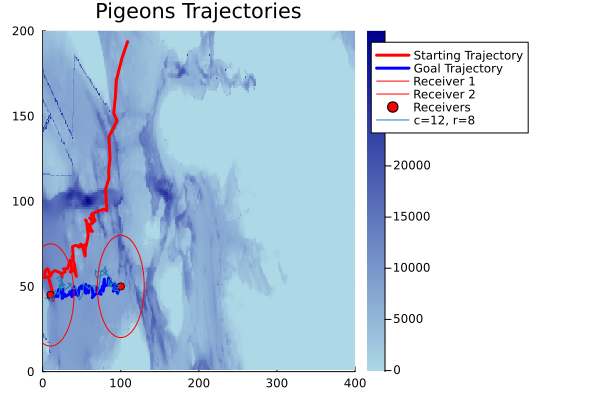

Log-posterior initial bridge: -1053.7956374173737
Log-posterior depth bridge: -685.4690703893851
Log-posterior pigeons: -702.0976395628448


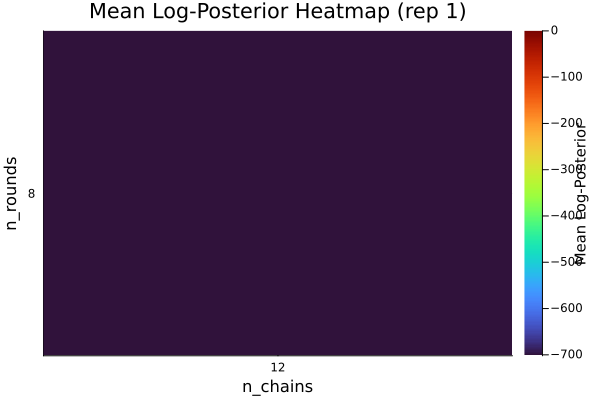

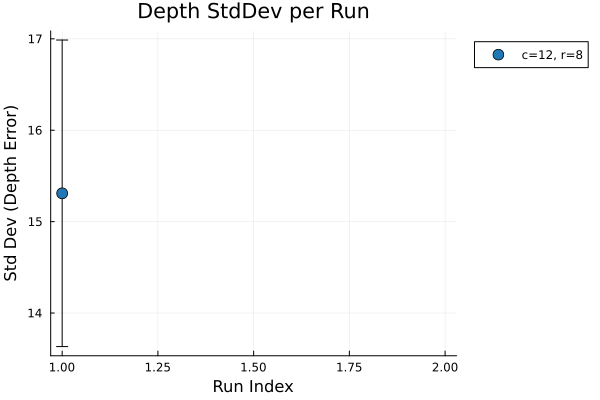

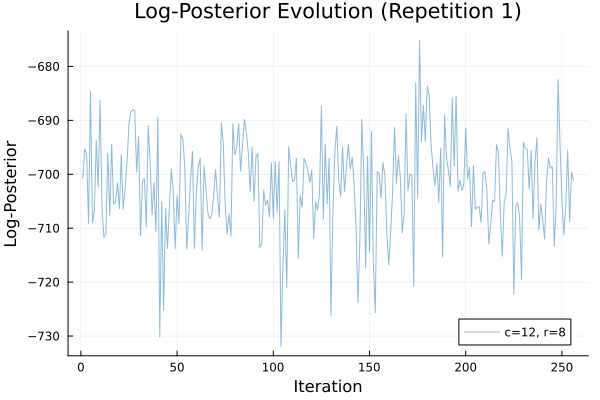

In [6]:
gr()
c=n_chains_list[1]
r=n_rounds_list[1]
# Style maps
colors_map = Dict(nc => palette(:tab10)[i] for (i, nc) in enumerate(n_chains_list))
linestyles_map = Dict(nr => [:solid, :dash, :dot, :dashdot, :dashdotdot, :solid][i] for (i, nr) in enumerate(n_rounds_list))
markers_map = Dict(nr => [:circle, :star5, :diamond, :utriangle, :square, :xcross][i] for (i, nr) in enumerate(n_rounds_list))

#TRAJECTORY PLOT
plt = heatmap(bathymetry_map[end:-1:1, :],
              xlim=(0, 400), ylim=(0, 200),
              color=:blues, title="Pigeons Trajectories", legend=:outertopright)

plot!(plt, xs, ys, lw=3, color=:red, label="Starting Trajectory")
plot!(plt, xs_d, ys_d, lw=3, color=:blue, label="Goal Trajectory")
plot!(plt, make_circle(receiver1.x, receiver1.y, receiver1.dist), color=:red, label="Receiver 1")
plot!(plt, make_circle(receiver2.x, receiver2.y, receiver2.dist), color=:red, label="Receiver 2")
scatter!(plt, [receiver1.x, receiver2.x], [receiver1.y, receiver2.y], color=:red, label="Receivers")

n_repeat = n_repeats
for (i, traj) in enumerate(all_trajectories)
    rep_index = mod(i - 1, n_repeat) + 1
    combo_index = div(i - 1, n_repeat)

    n_chains = n_chains_list[div(combo_index, length(n_rounds_list)) + 1]
    n_rounds = n_rounds_list[mod(combo_index, length(n_rounds_list)) + 1]

    xs_p = [p.x for p in traj]
    ys_p = [p.y for p in traj]

    plot!(plt, xs_p, ys_p,
          lw = 1,
          color = colors_map[n_chains],
          linestyle = linestyles_map[n_rounds],
          label = "c=$n_chains, r=$n_rounds")
end

display(plt)
savefig(plt, "images/repeated3/trajectories_$c-$r.svg")

v_init = TransformVariables.inverse(mapping, s_init)
v_depth = TransformVariables.inverse(mapping, s_depth)
logpost_init = fish_lp(v_init)
logpost_depth = fish_lp(v_depth)
println("Log-posterior initial bridge: ", logpost_init)
println("Log-posterior depth bridge: ", logpost_depth)
if (n_repeat==1)
    logpost_pg = mean(all_logposteriors[1])
    println("Log-posterior pigeons: ", logpost_pg)
end

#LOGPOST HEATMAPS FOR EACH REPETITION
xticks = (1:length(n_chains_list), string.(n_chains_list))
yticks = (1:length(n_rounds_list), string.(n_rounds_list))

for rep in 1:n_repeat
    mean_logpost_matrix = fill(NaN, length(n_rounds_list), length(n_chains_list))

    for i in 1:length(all_logposteriors)
        current_rep = mod(i - 1, n_repeat) + 1
        if current_rep == rep
            combo_index = div(i - 1, n_repeat)
            row = mod(combo_index, length(n_rounds_list)) + 1
            col = div(combo_index, length(n_rounds_list)) + 1
            mean_logpost_matrix[row, col] = mean(all_logposteriors[i])
        end
    end

    plt_heatmap = heatmap(
        mean_logpost_matrix;
        xlabel = "n_chains",
        ylabel = "n_rounds",
        xticks = xticks,
        yticks = yticks,
        colorbar_title = "Mean Log-Posterior",
        title = "Mean Log-Posterior Heatmap (rep $rep)",
        c = :turbo
    )
    annotate!(plt_heatmap, (2, 3, text("logpost_depth: $(round(logpost_depth, digits=2))", :black, :center, 10)))
    annotate!(plt_heatmap, (2, 2.5, text("logpost_init: $(round(logpost_init, digits=2))", :black, :center, 10)))

    display(plt_heatmap)
    savefig(plt_heatmap, "images/repeated3/logpost_heatmap_rep$rep-$c$r.svg")
end

#SCATTER PLOT OF STD DEVIATIONS
scatter_plot = plot(title="Depth StdDev per Run",
                    xlabel="Run Index", ylabel="Std Dev (Depth Error)", legend=:outertopright)

for i in 1:length(std_devs)
    rep_index = mod(i - 1, n_repeat) + 1
    combo_index = div(i - 1, n_repeat)

    n_chains = n_chains_list[div(combo_index, length(n_rounds_list)) + 1]
    n_rounds = n_rounds_list[mod(combo_index, length(n_rounds_list)) + 1]

    N = length(all_trajectories[i])
    sem = 15 / sqrt(N)

    scatter!(scatter_plot, [i], [std_devs[i]],
             yerr = [sem],
             markersize = 6,
             marker = markers_map[n_rounds],
             color = colors_map[n_chains],
             label = "c=$n_chains, r=$n_rounds")
end

display(scatter_plot)
savefig(scatter_plot, "images/repeated3/stddev_per_run_$c-$r.svg")

#LOGPOST EVOLUTION
for rep in 1:n_repeat
    plt_log = plot(
        title = "Log-Posterior Evolution (Repetition $rep)",
        xlabel = "Iteration",
        ylabel = "Log-Posterior"
    )

    for (i_nc, n_chains) in enumerate(n_chains_list)
        for (i_nr, n_rounds) in enumerate(n_rounds_list)
            # Compute the index in all_logposteriors
            # order: first vary rounds, then chains, then repetitions
            index = (rep - 1) * length(n_chains_list) * length(n_rounds_list) +
                    (i_nc - 1) * length(n_rounds_list) + i_nr

            lp = all_logposteriors[index]

            plot!(
                plt_log, lp;
                color = colors_map[n_chains],
                linestyle = linestyles_map[n_rounds],
                alpha = 0.5,
                label = "c=$n_chains, r=$n_rounds"
            )
        end
    end

    display(plt_log)
    savefig(plt_log, "images/repeated3/logpost_repetition_$rep-$c-$r.svg")
end